In [3]:
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error

import lightgbm as lgb; print('lightgbm version :', lgb.__version__)
from lightgbm.callback import early_stopping

warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

sns.set(rc = {"figure.figsize" : (15,8)})
sns.set_style('white')
plt.rc("axes", unicode_minus=False) # 음수값 깨지는 폰트 설정
plt.rc('font', family='NanumBarunGothic')

RANDOM_SEED = 42

lightgbm version : 4.3.0


* 데이터 샘플
    * DO (Dissolved Oxygen, 용존 산소, ㎎/L)
    * BOD (Biochemical Oxygen Demand, 생물학적 산소 요구량, ㎎/L)
    * COD (Chemical Oxygen Demand, 화학적 산소 요구량, ㎎/L)
    * SS (Suspended Solids, 부유 고형물, ㎎/L)
    * TN (Total Nitrogen, 총 질소, ㎎/L)
    * TP (Total Phosphorus, 총 인, ㎎/L)
    * TOC (Total Organic Carbon, 총 유기 탄소, ㎎/L)

* 전체 데이터셋을 합쳐서 확인하기

In [6]:
xlsx_file = '수질데이터.xlsx'
xls = pd.ExcelFile(xlsx_file, engine='openpyxl')

# 모든 시트 이름 가져오기
sheet_names = xls.sheet_names
print(sheet_names)

['경기도_수질데이터', '강원도_수질데이터', '충청도_수질데이터', '전라도_광주_수질데이터']


In [10]:
# 빈 데이터프레임 초기화
wq_data = pd.DataFrame()

for sheet_name in sheet_names:
    # 현재 시트의 데이터 불러오기
    df = pd.read_excel(xlsx_file, sheet_name=sheet_name, engine='openpyxl', skiprows=1, header=0)
    # 데이터프레임 합치기
    wq_data = pd.concat([wq_data, df], ignore_index=True)

# 합쳐진 데이터 확인
display(wq_data)

,측정소명,년,월,수온(℃),DO(㎎/L),BOD(㎎/L),COD(㎎/L),SS(㎎/L),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),총대장균군수(총대장균군수/100ml),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),클로로필 a(㎎/㎥),분원성대장균군수,유량(㎥/s)
0,이포,2021,1,3.6,13.6,0.8,3.1,2.2,3.097,0.027,1.8,8.2,320,205,3.076,0.130,2.730,0.014,0.007,2.3,41,106.568
1,이포,2021,2,4.4,13.9,1.1,3.8,3.6,3.036,0.028,2.1,8.5,311,34,2.943,0.107,2.669,0.010,0.002,11.0,12,87.608
2,이포,2021,3,9.7,12.8,2.9,5.2,16.7,2.993,0.072,2.9,8.7,296,4996,2.793,0.097,2.444,0.017,0.007,34.1,1350,146.800
3,이포,2021,4,14.0,12.7,2.2,4.8,11.0,2.611,0.046,2.9,8.9,273,1428,2.535,0.031,2.216,0.012,0.004,30.2,643,156.350
4,이포,2021,5,16.7,9.6,1.8,5.2,27.6,2.891,0.122,3.4,8.1,285,17980,2.699,0.188,2.196,0.048,0.038,18.7,7900,201.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,광주천2,2023,8,30.9,8.3,5.1,8.6,8.7,3.170,0.172,6.1,7.8,323,45000,2.840,0.584,1.800,0.101,0.082,19.7,1100,1.069
1715,광주천2,2023,9,25.9,6.9,2.6,5.7,4.7,2.596,0.148,4.0,7.4,262,36000,2.545,0.256,1.924,0.109,0.095,8.3,600,2.338
1716,광주천2,2023,10,18.6,9.9,4.1,7.1,9.4,4.625,0.108,5.5,7.8,371,64000,4.420,0.138,3.748,0.051,0.039,25.5,470,1.012
1717,광주천2,2023,11,11.9,9.0,5.1,8.7,20.6,5.151,0.216,6.7,7.3,342,720000,4.858,1.571,2.611,0.114,0.101,9.7,42000,3.025


* 측정소명 별 데이터 개수 (12개/1년, 총 3년)
    * 데이터가 부족한 측정소
        * 옥동천3:35
        * 섬강6:35
        * 섬강3:34
        * 운계천:34
        * 주천강3:33

In [11]:
print("측정소 수 :", len(wq_data['측정소명'].unique()))
print("총 데이터 수 :", len(wq_data))
wq_data['측정소명'].value_counts()

측정소 수 : 48
총 데이터 수 : 1719


측정소명
이포       36
묵현천      36
춘성교      36
충주       36
미호강5     36
무심천3     36
정안천      36
유구천      36
정동       36
금천       36
논산천4     36
강경       36
곡교천2     36
가막       36
전주       36
전주천7     36
김제       36
동진강3     36
관촌       36
동복천2     36
계산       36
광산       36
우치       36
소양강2     36
화천       36
황구지천4    36
황구지천1    36
탄천5      36
행주       36
공릉천5     36
신천5      36
팔당       36
왕숙천6     36
오산천2     36
오산천4     36
오산천6     36
광주천2     36
황구지천5    36
황구지천6    36
진위천5     36
진위천6     36
평창강5     36
원주       36
옥동천3     35
섬강6      35
섬강3      34
운계천      34
주천강3     33
Name: count, dtype: int64

* 월 피쳐 변경

In [12]:
wq_data['월_cos'] = np.cos(2 * np.pi * wq_data['월'] / 12)
wq_data['월_sin'] = np.sin(2 * np.pi * wq_data['월'] / 12)

* 총 피쳐명

In [13]:
feature_list = wq_data.columns.tolist()
feature_list

['측정소명',
 '년',
 '월',
 '수온(℃)',
 'DO(㎎/L)',
 'BOD(㎎/L)',
 'COD(㎎/L)',
 'SS(㎎/L)',
 'TN(㎎/L)',
 'TP(㎎/L)',
 'TOC(㎎/L)',
 '수소이온농도',
 '전기전도도(μS/㎝)',
 '총대장균군수(총대장균군수/100ml)',
 '용존총질소(㎎/L)',
 '암모니아성 질소(㎎/L)',
 '질산성 질소(㎎/L)',
 '용존총인(㎎/L)',
 '인산염인(㎎/L)',
 '클로로필 a(㎎/㎥)',
 '분원성대장균군수',
 '유량(㎥/s)',
 '월_cos',
 '월_sin']

* DO(㎎/L)의 분포

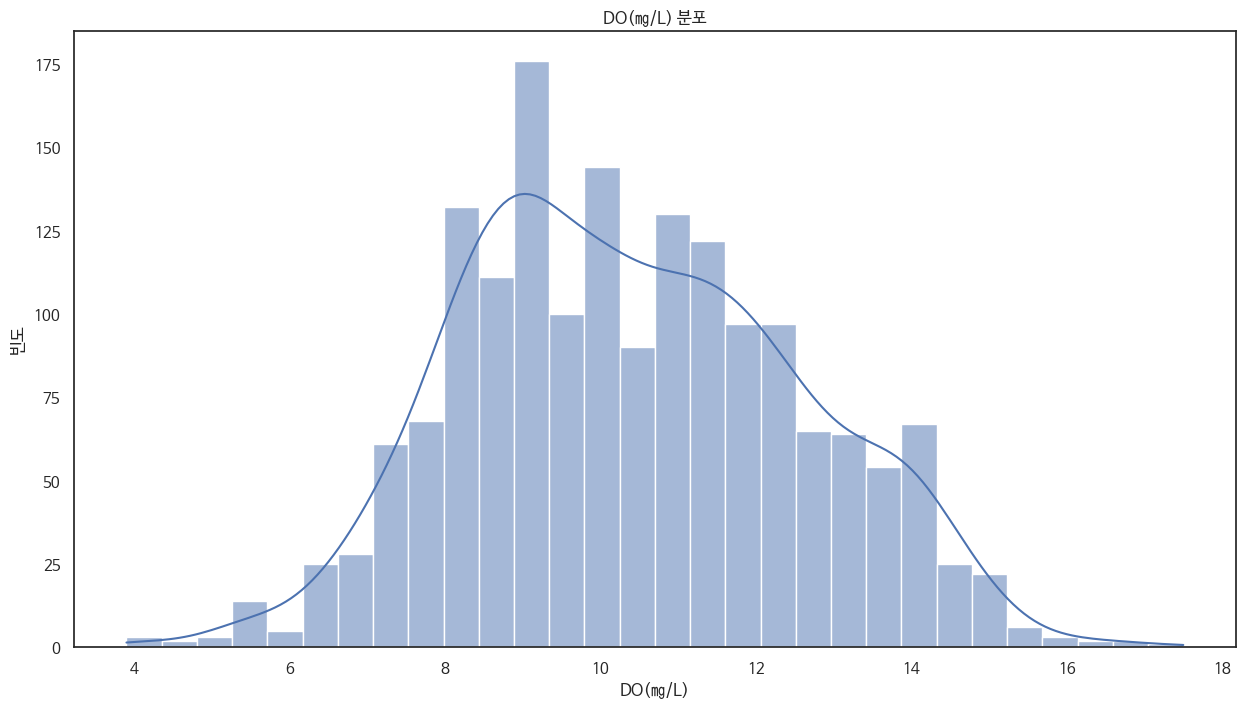

In [17]:
sns.histplot(wq_data["DO(㎎/L)"], kde=True, bins=30)
plt.title('DO(㎎/L) 분포')
plt.xlabel('DO(㎎/L)')
plt.ylabel('빈도')
plt.show()

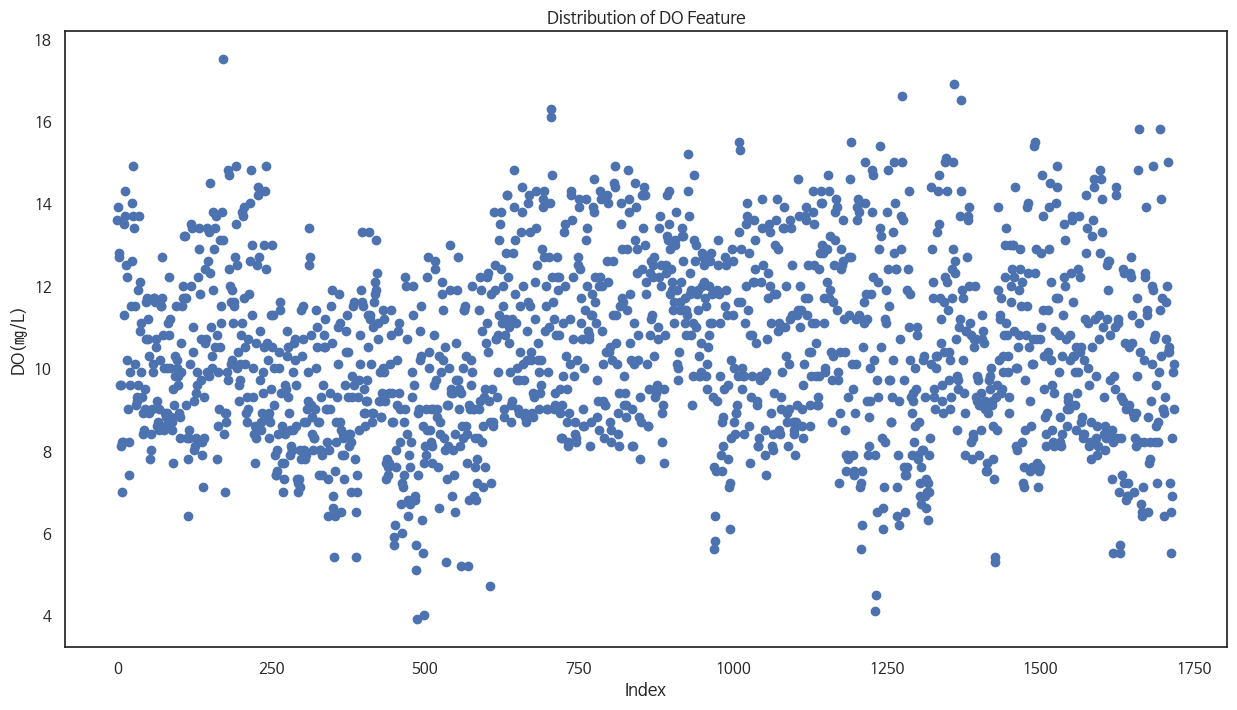

In [15]:
plt.scatter(range(len(wq_data)), wq_data['DO(㎎/L)'])
plt.xlabel('Index')
plt.ylabel('DO(㎎/L)')
plt.title('Distribution of DO Feature')
plt.show()

* 중요한 종속변수 찾기

In [18]:
feature_X = [
    '월_cos',
    '월_sin',
    '수온(℃)',
    'BOD(㎎/L)',
    'COD(㎎/L)',
    'SS(㎎/L)',
    'TN(㎎/L)',
    'TP(㎎/L)',
    'TOC(㎎/L)',
    '수소이온농도',
    '전기전도도(μS/㎝)',
    '총대장균군수(총대장균군수/100ml)',
    '용존총질소(㎎/L)',
    '암모니아성 질소(㎎/L)',
    '질산성 질소(㎎/L)',
    '용존총인(㎎/L)',
    '인산염인(㎎/L)',
    '클로로필 a(㎎/㎥)',
    '분원성대장균군수',
    '유량(㎥/s)',
]

wq_X = wq_data[feature_X]

feature_Y = ['DO(㎎/L)']
wq_Y = wq_data[feature_Y]
print("wq_X.shape :", wq_X.shape)
display(wq_X.head())
print("wq_Y.shape :", wq_Y.shape)
display(wq_Y.head())

## 인코딩
number_cols = wq_X.select_dtypes(include=['float64','int64']).columns
for col in number_cols:
    ss = StandardScaler()
    # .loc를 사용하여 명확하게 특정 열에 대한 변경을 적용합니다.
    wq_X.loc[:, col] = ss.fit_transform(wq_X[[col]])
    
print("after ss :")
display(wq_X.head())
display(wq_Y.head())

wq_X.shape : (1719, 20)


,월_cos,월_sin,수온(℃),BOD(㎎/L),COD(㎎/L),SS(㎎/L),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),총대장균군수(총대장균군수/100ml),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),클로로필 a(㎎/㎥),분원성대장균군수,유량(㎥/s)
0,8.660254e-01,0.500000,3.6,0.8,3.1,2.2,3.097,0.027,1.8,8.2,320,205,3.076,0.130,2.730,0.014,0.007,2.3,41,106.568
1,5.000000e-01,0.866025,4.4,1.1,3.8,3.6,3.036,0.028,2.1,8.5,311,34,2.943,0.107,2.669,0.010,0.002,11.0,12,87.608
2,6.123234e-17,1.000000,9.7,2.9,5.2,16.7,2.993,0.072,2.9,8.7,296,4996,2.793,0.097,2.444,0.017,0.007,34.1,1350,146.800
3,-5.000000e-01,0.866025,14.0,2.2,4.8,11.0,2.611,0.046,2.9,8.9,273,1428,2.535,0.031,2.216,0.012,0.004,30.2,643,156.350
4,-8.660254e-01,0.500000,16.7,1.8,5.2,27.6,2.891,0.122,3.4,8.1,285,17980,2.699,0.188,2.196,0.048,0.038,18.7,7900,201.480


wq_Y.shape : (1719, 1)


,DO(㎎/L)
0,13.6
1,13.9
2,12.8
3,12.7
4,9.6


after ss :


,월_cos,월_sin,수온(℃),BOD(㎎/L),COD(㎎/L),SS(㎎/L),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),총대장균군수(총대장균군수/100ml),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),클로로필 a(㎎/㎥),분원성대장균군수,유량(㎥/s)
0,1.232797,0.709885,-1.628135,-0.725816,-0.890900,-0.565794,-0.454810,-0.762885,-1.069088,0.705543,-0.344242,-0.122518,-0.414008,-0.405376,-0.143120,-0.723188,-0.697101,-0.570233,-0.108963,0.459839
1,0.714470,1.226851,-1.525476,-0.604764,-0.680431,-0.467484,-0.476197,-0.752945,-0.924249,1.287236,-0.366789,-0.122945,-0.461847,-0.421778,-0.179845,-0.783696,-0.785435,-0.270174,-0.109091,0.318934
2,0.006421,1.416073,-0.845357,0.121544,-0.259495,0.452415,-0.491274,-0.315593,-0.538013,1.675031,-0.404368,-0.110552,-0.515801,-0.428909,-0.315307,-0.677807,-0.697101,0.526535,-0.103228,0.758830
3,-0.701628,1.226851,-0.293563,-0.160909,-0.379763,0.052153,-0.625208,-0.574028,-0.538013,2.062826,-0.461988,-0.119463,-0.608602,-0.475976,-0.452575,-0.753442,-0.750101,0.392025,-0.106326,0.829802
4,-1.219956,0.709885,0.052912,-0.322311,-0.259495,1.217827,-0.527036,0.181397,-0.296615,0.511646,-0.431925,-0.078124,-0.549612,-0.364015,-0.464616,-0.208867,-0.149432,-0.004605,-0.074530,1.165193


,DO(㎎/L)
0,13.6
1,13.9
2,12.8
3,12.7
4,9.6


In [19]:
## 파라미터 설정
lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': 42,
    'metric': ['mse'],
    'verbose': -1,
}

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

## Feature Importance 추출
def get_FI_lgb(X_train, y_train, lgb_param):

    folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    oof = np.zeros(len(X_train))
    feature_importance_df = pd.DataFrame()
    params = {'verbose': -1}
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx], params=params)
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
        num_round = 100000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data], callbacks=[early_stopping(stopping_rounds=200, verbose=True)])
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
        cv_fold_score = mse(y_train.iloc[val_idx], oof[val_idx])
        print("cv_fold_score :", cv_fold_score)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = mse(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')
    return feature_importance_df, y_train, oof

feature_importance_df, y_train, oof = get_FI_lgb(wq_X, wq_Y, lgb_param)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[506]	training's l2: 0.074316	valid_1's l2: 0.713548
cv_fold_score : 0.7135480990171018
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[891]	training's l2: 0.0233983	valid_1's l2: 0.659081
cv_fold_score : 0.6590814044626887
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[281]	training's l2: 0.161754	valid_1's l2: 0.625669
cv_fold_score : 0.6256685081216958
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[983]	training's l2: 0.0178746	valid_1's l2: 0.640473
cv_fold_score : 0.640472644837676
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[904]	training's l2: 0.0246848	valid_1's l2: 0.578476
cv_fold_score : 0.5784765194551681
CV-Score: 0.643487


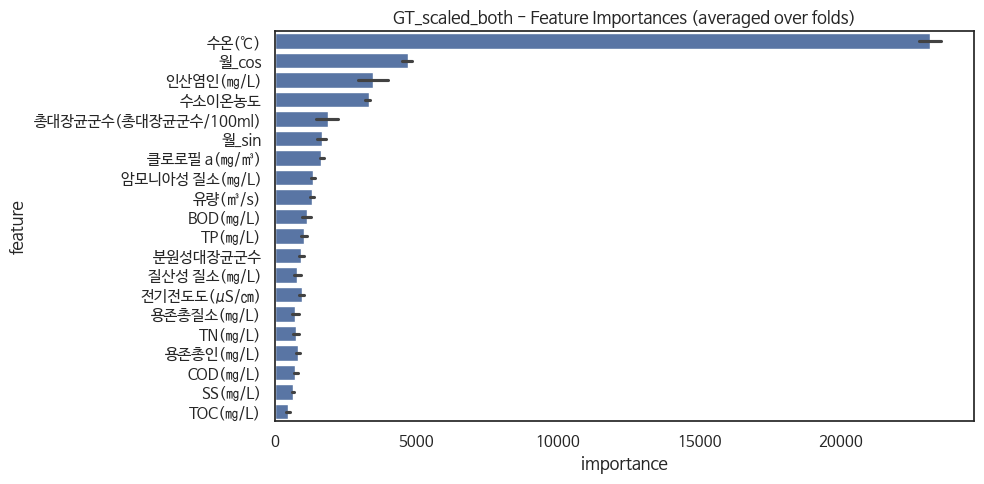

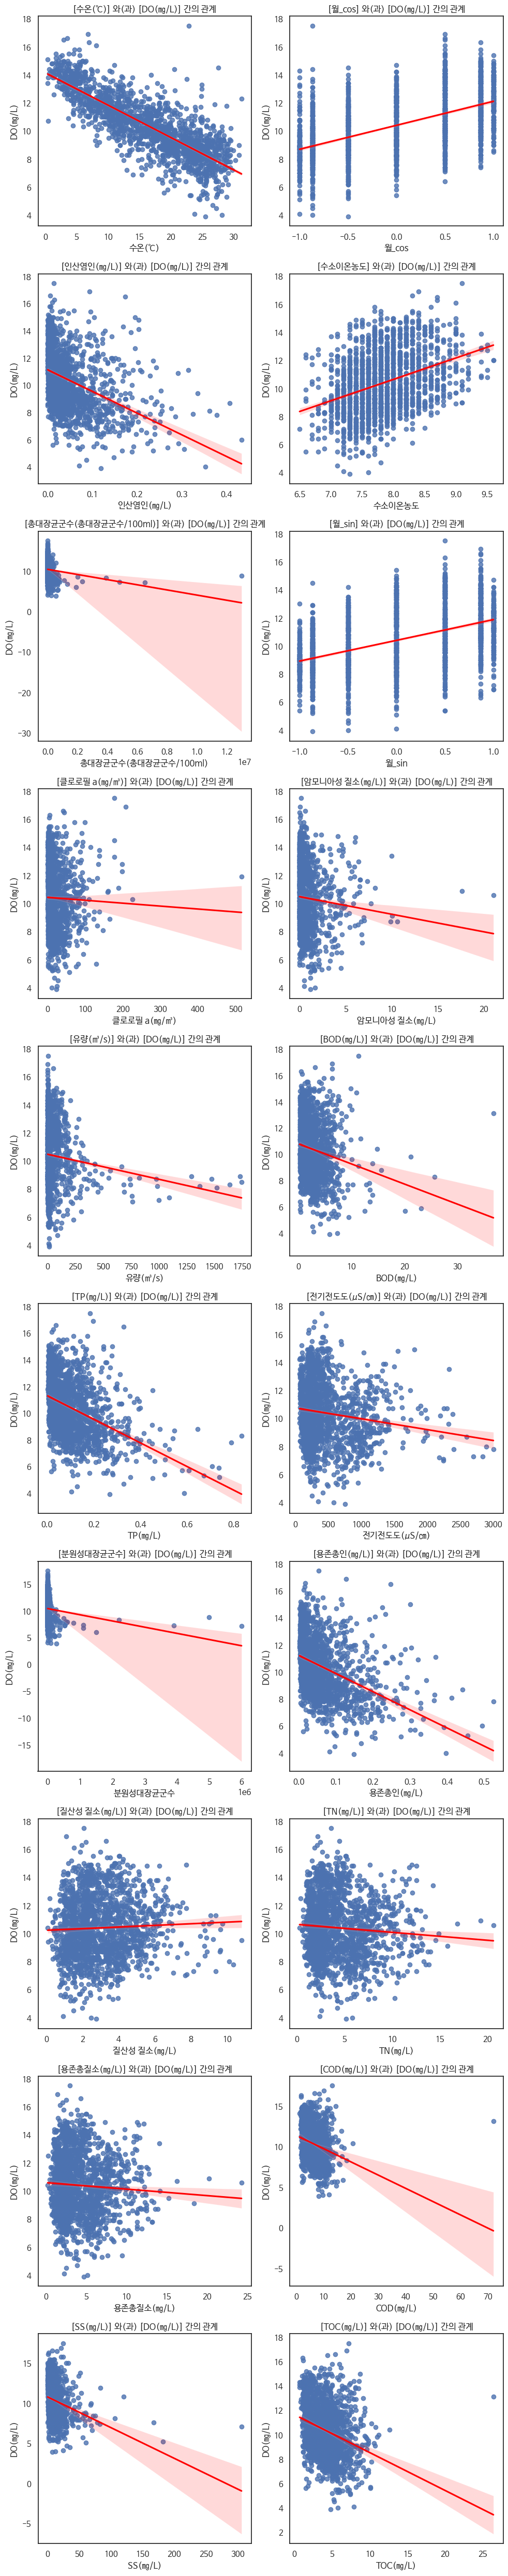

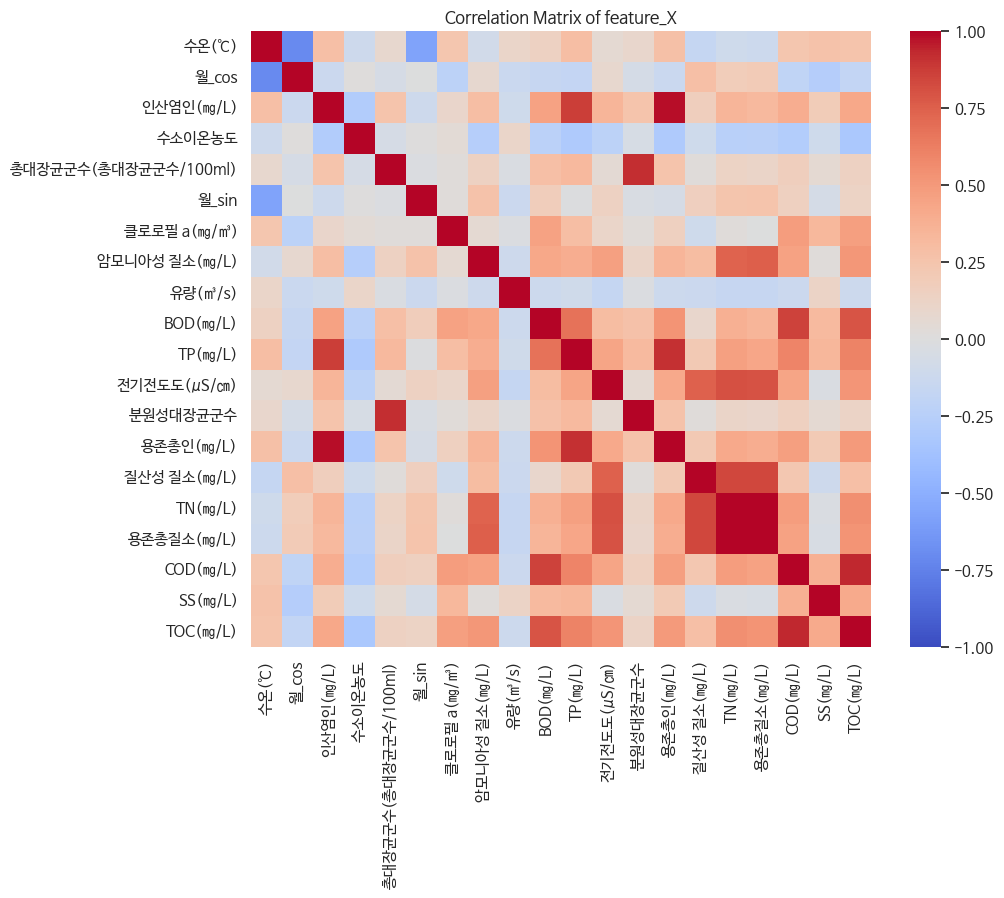

In [20]:
## Feature Importance 확인
plt.figure(figsize=(10,5))

cols = (feature_importance_df[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_both - Feature Importances (averaged over folds)')
plt.tight_layout()
plt.show()

# Feature importance 순 DO(㎎/L)] 간의 Correlation plot
num_rows = int(len(wq_X.columns) / 2)
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2.5 * len(wq_X.columns)))

for i, feature in enumerate(cols):
    row = i // num_cols
    col = i % num_cols
    sns.regplot(data=wq_data, x=feature, y='DO(㎎/L)', line_kws={'color': 'red'}, ax=axes[row, col])
    axes[row, col].set_title(f'[{feature}] 와(과) [DO(㎎/L)] 간의 관계')

plt.tight_layout()
plt.show()

# feature_X 데이터프레임의 상관관계 매트릭스 계산
corr_matrix = wq_X[cols].corr()

# feature importance 순서에 따라 정렬된 상관관계 매트릭스 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of feature_X')
plt.show()

fold 1 - mse : 0.9550892886996133
fold 2 - mse : 0.8856827729141233
fold 3 - mse : 0.9652186324371713
fold 4 - mse : 1.1040089932910908
fold 5 - mse : 1.1000818742338927
CV-Score: 1.002016


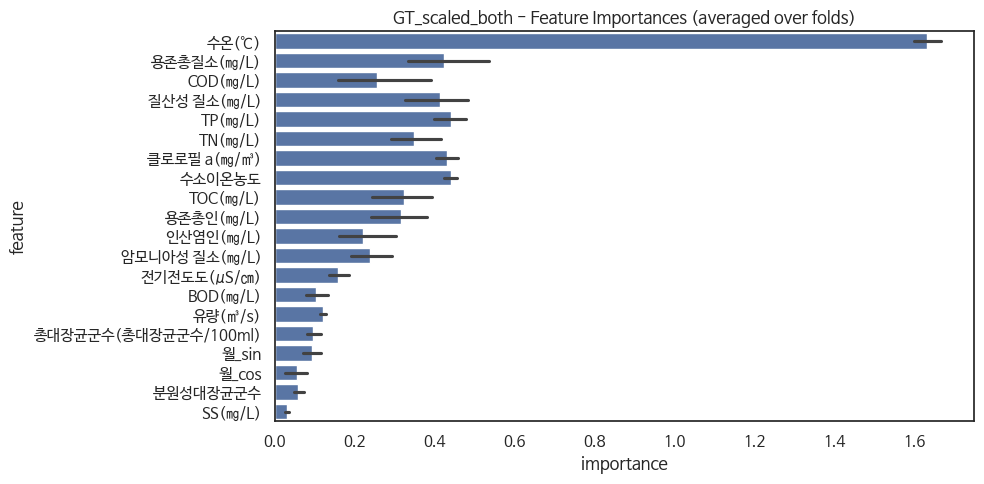

In [22]:
TOTAL_SCORE = 0
oof = np.zeros(len(wq_X))
feature_importance_df = pd.DataFrame()

folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(wq_X.values, wq_Y.values)):
    wq_X_train, wq_Y_train = wq_X.iloc[trn_idx], wq_Y.iloc[trn_idx]
    wq_X_valid, wq_Y_valid = wq_X.iloc[val_idx], wq_Y.iloc[val_idx]
    
    wq_Y_train_1d = wq_Y_train.values.ravel()
    wq_Y_valid_1d = wq_Y_valid.values.ravel()
    
    lr = LinearRegression()
    lr.fit(wq_X_train, wq_Y_train_1d)
    
    pred = lr.predict(wq_X_valid)
    score = mse(wq_Y_valid_1d, pred)
    TOTAL_SCORE += score
    print(f'fold {fold_ + 1} - mse : {score}')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = wq_X.columns.tolist()
    fold_importance_df['importance'] = np.abs(lr.coef_)
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
feature_importance_df.reset_index(drop=True, inplace=True)    
print(f'CV-Score: {TOTAL_SCORE/5:.6f}')

## Feature Importance 확인
plt.figure(figsize=(10,5))

cols = (feature_importance_df[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_both - Feature Importances (averaged over folds)')
plt.tight_layout()
plt.show()

* 경기도에서 학습한 Linear model로 다른 지역 추론

In [23]:
xlsx_file = '수질데이터.xlsx'
xls = pd.ExcelFile(xlsx_file, engine='openpyxl')

# 모든 시트 이름 가져오기
sheet_names = xls.sheet_names
print(sheet_names)

['경기도_수질데이터', '강원도_수질데이터', '충청도_수질데이터', '전라도_광주_수질데이터']


In [29]:
# 경기도 수질 데이터
ggd_data = pd.read_excel(xlsx_file, sheet_name="경기도_수질데이터", engine='openpyxl', skiprows=1, header=0)

# 그 외 지역 수질 데이터
gwd_data = pd.read_excel(xlsx_file, sheet_name="강원도_수질데이터", engine='openpyxl', skiprows=1, header=0)
ccd_data = pd.read_excel(xlsx_file, sheet_name="충청도_수질데이터", engine='openpyxl', skiprows=1, header=0)
jld_data = pd.read_excel(xlsx_file, sheet_name="전라도_광주_수질데이터", engine='openpyxl', skiprows=1, header=0)

# 월 피쳐
ggd_data['월_cos'] = np.cos(2 * np.pi * ggd_data['월'] / 12)
ggd_data['월_sin'] = np.sin(2 * np.pi * ggd_data['월'] / 12)
gwd_data['월_cos'] = np.cos(2 * np.pi * gwd_data['월'] / 12)
gwd_data['월_sin'] = np.sin(2 * np.pi * gwd_data['월'] / 12)
ccd_data['월_cos'] = np.cos(2 * np.pi * ccd_data['월'] / 12)
ccd_data['월_sin'] = np.sin(2 * np.pi * ccd_data['월'] / 12)
jld_data['월_cos'] = np.cos(2 * np.pi * jld_data['월'] / 12)
jld_data['월_sin'] = np.sin(2 * np.pi * jld_data['월'] / 12)

# 인코딩
ggd_X = ggd_data[feature_X]
ggd_Y = ggd_data[feature_Y]
gwd_X = gwd_data[feature_X]
gwd_Y = gwd_data[feature_Y]
ccd_X = ccd_data[feature_X]
ccd_Y = ccd_data[feature_Y]
jld_X = jld_data[feature_X]
jld_Y = jld_data[feature_Y]


## 인코딩
number_cols = ggd_X.select_dtypes(include=['float64','int64']).columns
for col in number_cols:
    ss = StandardScaler()
    ggd_X.loc[:, col] = ss.fit_transform(ggd_X[[col]])
    gwd_X.loc[:, col] = ss.fit_transform(gwd_X[[col]])
    ccd_X.loc[:, col] = ss.fit_transform(ccd_X[[col]])
    jld_X.loc[:, col] = ss.fit_transform(jld_X[[col]])

In [34]:
# 선형 회귀 모델 초기화 및 학습
model = LinearRegression()
model.fit(ggd_X, ggd_Y)

# 나머지 지역 데이터에 대한 예측
predictions_region1 = model.predict(gwd_X)
predictions_region2 = model.predict(ccd_X)
predictions_region3 = model.predict(jld_X)

# MSE 계산
mse_region1 = mse(gwd_Y, predictions_region1)
mse_region2 = mse(ccd_Y, predictions_region2)
mse_region3 = mse(jld_Y, predictions_region3)

print(f"강원도 MSE: {mse_region1}")
print(f"충청도 MSE: {mse_region2}")
print(f"전라도 광주 MSE: {mse_region3}")

강원도 MSE: 3.547352244779219
충청도 MSE: 2.14955832070713
전라도 광주 MSE: 1.688801194127779
